# Kaggle connection and data downloading

In [ ]:
import os
from google.colab import files

In [ ]:
!pip install -q kaggle

In [ ]:
print("Please upload your 'kaggle.json' file:")
uploaded = files.upload()

# Check if the file was uploaded
if 'kaggle.json' in uploaded:
    print("\n'kaggle.json' uploaded successfully!")

    # Create the.kaggle directory and move the file there
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/

    # Set the required permissions for the file
    !chmod 600 ~/.kaggle/kaggle.json

    print("Kaggle API is now configured.")
else:
    print("\nUpload failed. Please make sure you select the 'kaggle.json' file.")

Please upload your 'kaggle.json' file:


Saving kaggle.json to kaggle.json

'kaggle.json' uploaded successfully!
Kaggle API is now configured.


In [ ]:
!kaggle datasets download -d ebrahimelgazar/pixel-art

Dataset URL: https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art
License(s): apache-2.0
  0% 0.00/85.7M [00:00<?, ?B/s]
100% 85.7M/85.7M [00:00<00:00, 1.41GB/s]


In [ ]:
dataset_zip_path = 'pixel-art.zip'
extract_path = '/content/pixel_art_dataset'

In [ ]:
import zipfile

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to `{extract_path}`")


Unzipping `pixel-art.zip`...
Dataset extracted to `/content/pixel_art_dataset`


# Visualisation by class

--- Found Unique Labels ---
[0. 0. 0. 0. 1.]
[0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
------------------------------

Generating 5 random examples for each label...


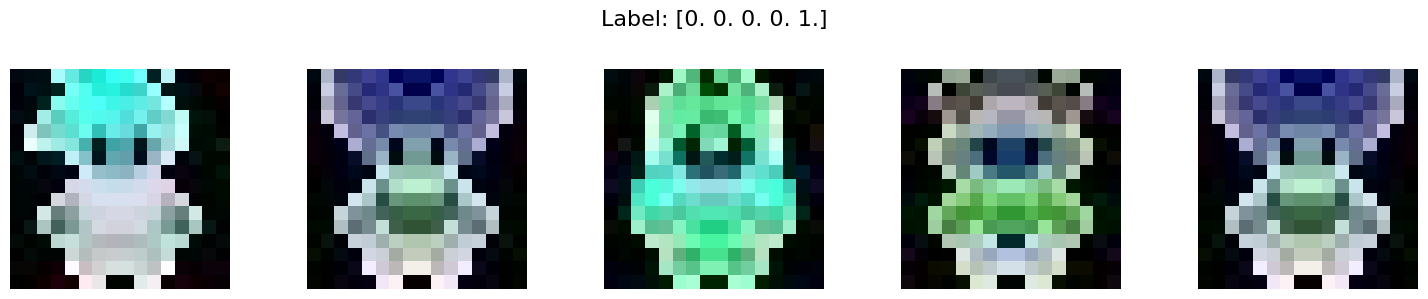

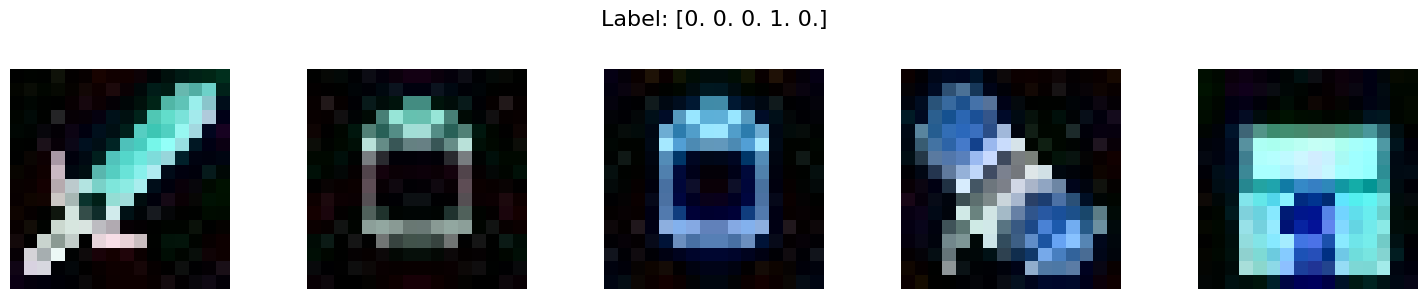

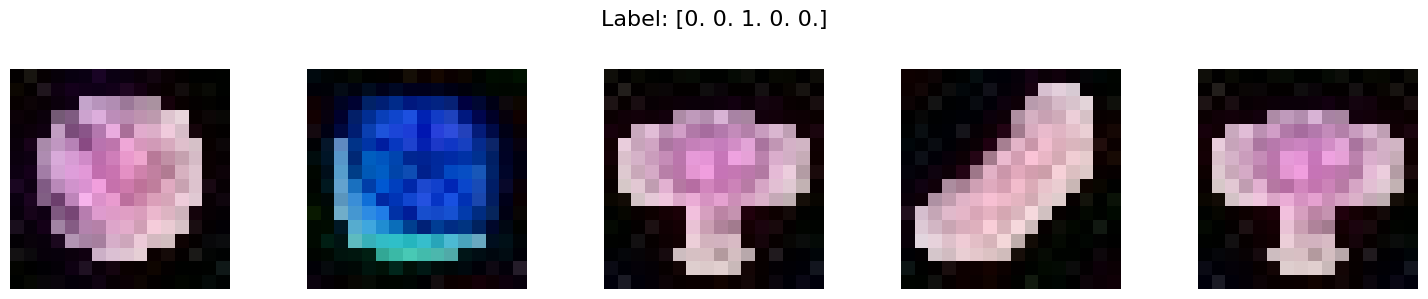

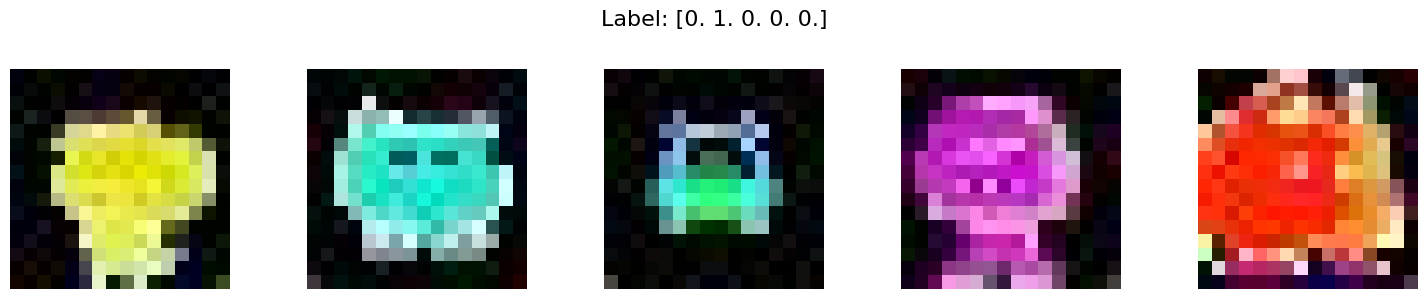

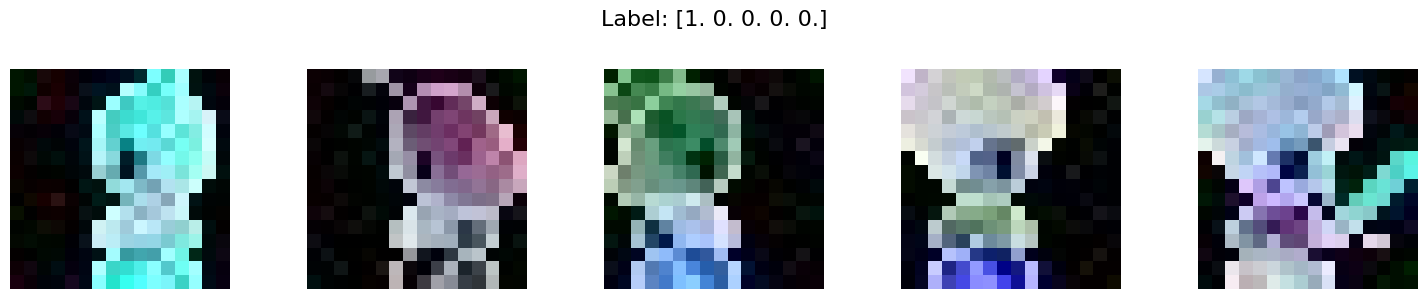

In [34]:
LABELS_CSV_PATH = '/content/pixel_art_dataset/labels.csv'
IMAGE_DIRECTORY_PATH = '/content/pixel_art_dataset/images/images/'


labels_df = pd.read_csv(LABELS_CSV_PATH)

unique_labels = sorted(labels_df['Label'].unique())

print("--- Found Unique Labels ---")
for label in unique_labels:
    print(label)
print("-" * 30)



# Loop through each unique label string
for label_str in unique_labels:

    # Get all rows from the DataFrame that match the current label
    label_specific_df = labels_df[labels_df['Label'] == label_str]

    # Get the corresponding image indices
    image_indices = label_specific_df['Image Index'].tolist()

    # Randomly select 5 indices from the list for visualization
    sample_indices = random.sample(image_indices, 5)

    # Create a plot to display the 5 sample images in a row
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    # Set the title of the plot to be the raw label string
    fig.suptitle(f'Label: {label_str}', fontsize=16)

    # Display each of the 5 selected images
    for i, img_index in enumerate(sample_indices):

        # Construct the full path to the image file
        img_filename = f'image_{img_index}.JPEG'
        img_path = os.path.join(IMAGE_DIRECTORY_PATH, img_filename)

        # Open the image and show it on the plot
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off') # Hide the x and y axes for a cleaner look

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()